In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu, tanh

import numpy as np
import matplotlib.pyplot as plt

In [9]:
from deepshape.curves import *

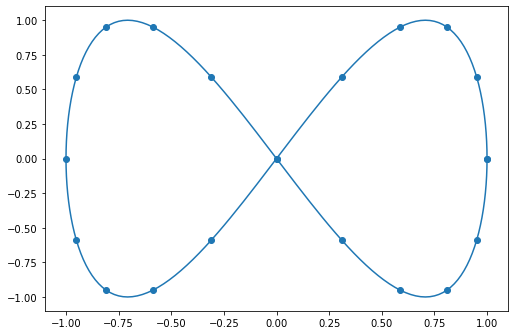

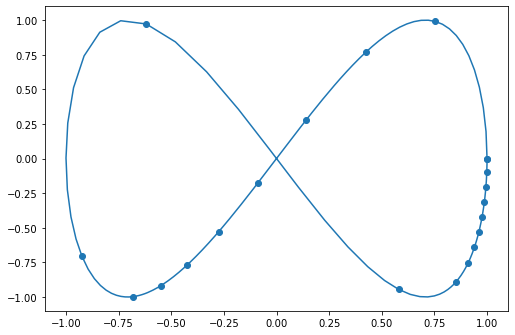

In [10]:
# Load test curves
g = Diffeomorphism(
    lambda x: (0.5 * torch.log(20*x+1) / torch.log(21*torch.ones(1)) 
    + 0.25 * (1 + torch.tanh(20*(x-0.5)) / torch.tanh(21*torch.ones(1))))
)

c1 = Curve((
    lambda x: torch.cos(2*pi*x),
    lambda x: torch.sin(4*pi*x)
))

c2 = c1.compose(g)


# Take Qmaps
q, r = Qmap(c2), Qmap(c1)

plt.figure(figsize=(8.3, 5.6))
plot_curve(c1, dotpoints=21, ax=plt.gca())

plt.figure(figsize=(8.3, 5.6))
plot_curve(c2, dotpoints=21, ax=plt.gca())
plt.show()

In [11]:
######### 
# TEST: Spectral normalization algorithm
#########
test_iters = 100
input_size = 100
hidden_size = 110
c = 0.9
power_iters = 10

def power_iteration(W: torch.Tensor, iters: int):
    v = torch.rand(W.size(1))
    vnorm = v.norm()

    for i in range(iters):
        v = torch.mv( torch.mm(W.transpose(1, 0), W), v / vnorm )
        vnorm = v.norm()
        
    return (W @ v).norm() / vnorm

def spectral_normalization(W : torch.Tensor, c : float, iters: int):
    spec_norm = power_iteration(W, iters)
    W /= max(1., spec_norm / c)
    return W

def nuclear_normalization(W : torch.Tensor, c : float, iters: int):
    nuc_norm = torch.linalg.norm(W, 2)
    W /= max(1., nuc_norm / c)
    return W

for i in range(test_iters):
    v = torch.rand(input_size)
    W0 = 100 * torch.randn(hidden_size, input_size)
    W1 = nuclear_normalization(W0, c=0.95, iters=power_iters)
    assert torch.linalg.norm(W1, 2) < 1.

class SpectralDenseLayer(nn.Module):
    def __init__(self, input_dim: int, out_dim: int = 1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer1 = nn.Linear(input_dim, hidden_dim, bias=False)
        
    def forward(self, x):
#         return x + self.layer2(torch.tanh(self.layer1(x)))
        return min_max_norm(x + self.layer2(torch.tanh(self.layer1(x))))
    
    def project(self, c : float, iters: int = 5):
        self.layer1.weight = nuclear_normalization(self.layer1.weight, c, iters)
        self.layer2.weight = nuclear_normalization(self.layer2.weight, c, iters)
        
    def reparametrized(self, r, X):
        Z = min_max_norm(network(x))
        Y = central_diff_derivative(Z)
        return torch.sqrt(Y) * r(Z)
    
    
def min_max_norm(Z):
    return Z / (Z[-1] - Z[0]) + Z[0]

In [72]:
class SpectralDenseLayer(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, activation: str = "tanh", bias=False):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Init Weights
        self.linear = nn.Linear(input_dim, output_dim, bias=True)
#         self.project(c=0.9, iters=5)
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            raise ValueError(activation)
            
    def forward(self, x):
        return self.activation(self.linear(x))
        
    def project(self, c : float, iters: int = 5):
        with torch.no_grad():
            self.linear.weight = nuclear_normalization(self.linear.weight, c, iters)

In [73]:
class SpectralResidualLayer(nn.Module):
    def __init__(self, input_dim: int, hidden_layers: int, hidden_dim: int,
                 activation: str = "tanh"):
        super().__init__()
        
        # Create layer list
        self.layers = nn.ModuleList([SpectralDenseLayer(input_dim, hidden_dim, activation)])
        for _ in range(hidden_layers-1):
            self.layers.append(SpectralDenseLayer(hidden_dim, hidden_dim, activation))
        self.layers.append(SpectralDenseLayer(hidden_dim, input_dim, activation))
        
    def forward(self, x):
        y = x
        for layer in self.layers:
            y = layer(y)
        return x + y
    
    def project(self, c: float, iters: int = 5):
        with torch.no_grad():
            for layer in self.layers:
                layer.project(c, iters)

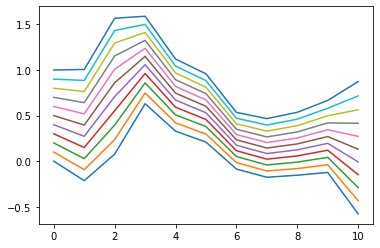

In [97]:
########################################################### 
# Test 1: Check that spectral_resnet indeed preserves order
###########################################################
add_iters = 1
input_size = 1
hidden_size = 256
c = 0.9
inner_layers = 1
outer_layers = 10
num_layers = 1


# # Create network with [num_layers layers]
network = nn.Sequential()
for l in range(outer_layers):
    network.add_module(f"SpectralResLayer{l}", SpectralResidualLayer(input_size, inner_layers, hidden_size))
network

# Data to be used.
x = torch.linspace(0, 1, 11).unsqueeze(-1)
Z = x.clone().transpose(0, 1)
y = x.clone()

# Multiple attempts
for i in range(add_iters):
    # Want to modify parameters without keeping track of operations.
    with torch.no_grad():
        for layer in next(network.modules()):
            y = layer(y)
            Z = torch.vstack((Z, y.clone().transpose(0, 1)))

        # Plot network.
        plt.figure()
        plt.plot(Z)
        plt.show()

        assert (np.diff(y.flatten()) > 0.0).all(), "Layer not invertible"

In [75]:
def train(q, r, network, optimizer, scheduler=None, loss=nn.MSELoss(), 
          npoints=1024, iterations=300, epsilon=None, log_every=10):
    """ General purpose function for training a curve reparametrization network,
    which works with most optimizers not requiring a closure.

    TODO: Implement as method of the network.
    """
    tic = time.time()
    
    # Initialize node placement
    x = torch.linspace(0, 1, npoints).unsqueeze(-1)
    
    # Evaluate initial error
    error = np.empty(iterations+1)
    error.fill(np.nan)
    # Find current reparametrized Q-maps
    Z = network(x)
    Y = central_diff_derivative(Z)
    Q = q(x)
    R = torch.sqrt(Y) * r(Z)
    error[0] = loss(R, Q) * 2


    for i in range(iterations):   
        x = torch.linspace(0, 1, npoints).unsqueeze(-1)
        
        # Set gradient buffers to zero.
        optimizer.zero_grad()

        # Find current reparametrized Q-maps
        Z = network(x)
        Y = central_diff_derivative(Z)
        Q = q(x)
        R = torch.sqrt(Y) * r(Z)

        # Compute loss, and perform a backward pass and gradient step
        l = loss(R, Q) * 2
        l.backward()

        if scheduler is not None:
            scheduler.step(l)
        
        optimizer.step()
        error[i+1] = l.item()

        # Projection step
        with torch.no_grad():
            for layer in next(network.modules()):
                layer.project(2.)

        if log_every > 0 and i % log_every == 0:
            print('[Iter %5d] loss: %.5f' %
                  (i + 1, l))        

    toc = time.time()

    print()
    print(f'Finished training in {toc - tic:.5f}s')
    return error


In [499]:
def spectral_resnet(hidden_size, num_layers):
    # Create network with [num_layers layers]
    network = nn.Sequential()
    for l in range(num_layers):
        network.add_module(f"SpectralDense{l}", SpectralDense(input_size, hidden_size))
    return network

def central_diff_derivative(x):
    out = torch.zeros_like(x)
    out[0] = x[1] - x[0]
    out[-1] = x[-1] - x[-2]
    out[1:-1] = 0.5 * (x[2:] - x[:-2])
    return out / x.size(0)

[Iter     1] loss: 8.14465
[Iter     2] loss: 8.14060
[Iter     3] loss: 8.14060
[Iter     4] loss: 8.14060
[Iter     5] loss: 8.14060
[Iter     6] loss: 8.14060
[Iter     7] loss: 8.14060
[Iter     8] loss: 8.14060
[Iter     9] loss: 8.14060
[Iter    10] loss: 8.14060

Finished training in 0.09978s


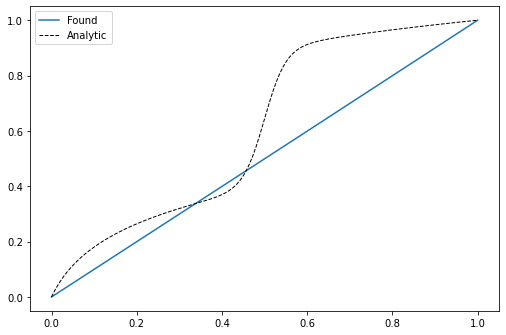

In [500]:
#
RN = spectral_resnet(256, 10)


# Choose and configure optimizer.
optimizer = optim.SGD(RN.parameters(), lr=1e-3)

scheduler=None
error = train(q, r, RN, optimizer, scheduler=scheduler, iterations=10, log_every=1)

# Create Plotting Data to verify reparametrizations
Npoints = 128
h = 1 / (Npoints )
x = torch.linspace(0, 1, Npoints).unsqueeze(-1)
z = min_max_norm(RN(x))
y = central_diff_derivative(z)
z, y = z.detach(), y.detach()
Q, R = q(x), torch.sqrt(y) * r(z)
R = R.detach()

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.legend()
plt.show()